# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, col, udf, when, countDistinct, sum, mean, desc

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import LinearSVC, RandomForestClassifier, LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import pi

%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify churn") \
    .getOrCreate()

---

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# read json of subset data
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
# quick look at a few rows to get an idea of data
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104834E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.76726201140994,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.7762634630741,NaN,31.50507848842214,1.5075439608226302E9,None,109091.9499991047
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


In [7]:
# Number of rows in df
df.count()

286500

In [8]:
# Unique userID
df.select('userId').dropDuplicates().count()

226

In [9]:
# check on missing values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


It is ok to have None values for `artist/length/song` when not on NextSong page.  
However, it seems we have missing values (8436) in user information columns (firstname, gender, lastname, location, registration) but there are no missing values in the `userId` or `sessionId` columns.  
Let's look at `userId`

In [10]:
df.select("userId").dropDuplicates().sort("userId").show(10)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
+------+
only showing top 10 rows



There are `userId` values that are empty strings. These are users who have not signed up yet or who are signed out and are about to log in.

In [11]:
# filter out userId with empty string
df_valid = df.filter(df["userId"] != "")

In [12]:
# keep valid userId => 286500 - 8346 = 278154
df_valid.count()

278154

In [13]:
df_valid.select('userId').dropDuplicates().count()

225

---

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [14]:
# Next cells continue with some preliminary data exploration then create the Churn column.

# Pages that users can visit 
df_valid.select("page").dropDuplicates().sort("page").show(truncate=False)

+-------------------------+
|page                     |
+-------------------------+
|About                    |
|Add Friend               |
|Add to Playlist          |
|Cancel                   |
|Cancellation Confirmation|
|Downgrade                |
|Error                    |
|Help                     |
|Home                     |
|Logout                   |
|NextSong                 |
|Roll Advert              |
|Save Settings            |
|Settings                 |
|Submit Downgrade         |
|Submit Upgrade           |
|Thumbs Down              |
|Thumbs Up                |
|Upgrade                  |
+-------------------------+



In [15]:
# look at level (free vs paid profiles) of users totals/ users can switchbetween levels
df_valid.groupBy("level").agg(countDistinct('userId')).show()

+-----+----------------------+
|level|count(DISTINCT userId)|
+-----+----------------------+
| free|                   195|
| paid|                   165|
+-----+----------------------+



In [16]:
# Churn definition: We define churner using the Cancellation Confirmation events

# Before adding the churn column let's have a look at a user's journey who cancelled 
df_valid.filter("page = 'Cancellation Confirmation'").show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|
|  nu

In [17]:
# Activities of a multiple sessions and paid user who cancelled
df_valid.select(["userId", "firstname", "page", "sessionId", "level", "song"]).where(df_valid.userId == "32").sort("ts").collect()

[Row(userId='32', firstname='Diego', page='NextSong', sessionId=218, level='free', song='Beyond The Beyond (Instrumental)'),
 Row(userId='32', firstname='Diego', page='NextSong', sessionId=218, level='free', song='Paradise City'),
 Row(userId='32', firstname='Diego', page='NextSong', sessionId=218, level='free', song='Alejandro'),
 Row(userId='32', firstname='Diego', page='Roll Advert', sessionId=218, level='free', song=None),
 Row(userId='32', firstname='Diego', page='NextSong', sessionId=218, level='free', song='Luv U Better'),
 Row(userId='32', firstname='Diego', page='Thumbs Up', sessionId=218, level='free', song=None),
 Row(userId='32', firstname='Diego', page='NextSong', sessionId=218, level='free', song='My Life Would Suck Without You'),
 Row(userId='32', firstname='Diego', page='Add to Playlist', sessionId=218, level='free', song=None),
 Row(userId='32', firstname='Diego', page='NextSong', sessionId=218, level='free', song='Jamaica Roots II(Agora E Sempre)'),
 Row(userId='32', 

#### Churn column creation

In [18]:
# Create a Churn column to use as the label for your model. 
# As suggested we use Cancellation Confirmation events to define our churn

# Find churners Ids
churners = (df_valid.filter(df_valid.page == 'Cancellation Confirmation')
                     .select('userId')
                     .distinct()
                     .rdd.flatMap(lambda row: row)
                     .collect())

# Churn = 1 if user cancelled/churned 0 otherwise
df_valid = df_valid.withColumn('Churn', when(df_valid.userId.isin(churners), 1).otherwise(0))

In [19]:
# percentage of churners
(len(churners)/df_valid.select('userID').dropDuplicates().count())*100

23.11111111111111

In [20]:
# check again our userId==18
df_valid.select(["userId", "firstname", "page", "sessionId", "level", "song", "Churn"]).where(df_valid.userId == "32").sort("ts").collect()

[Row(userId='32', firstname='Diego', page='NextSong', sessionId=218, level='free', song='Beyond The Beyond (Instrumental)', Churn=1),
 Row(userId='32', firstname='Diego', page='NextSong', sessionId=218, level='free', song='Paradise City', Churn=1),
 Row(userId='32', firstname='Diego', page='NextSong', sessionId=218, level='free', song='Alejandro', Churn=1),
 Row(userId='32', firstname='Diego', page='Roll Advert', sessionId=218, level='free', song=None, Churn=1),
 Row(userId='32', firstname='Diego', page='NextSong', sessionId=218, level='free', song='Luv U Better', Churn=1),
 Row(userId='32', firstname='Diego', page='Thumbs Up', sessionId=218, level='free', song=None, Churn=1),
 Row(userId='32', firstname='Diego', page='NextSong', sessionId=218, level='free', song='My Life Would Suck Without You', Churn=1),
 Row(userId='32', firstname='Diego', page='Add to Playlist', sessionId=218, level='free', song=None, Churn=1),
 Row(userId='32', firstname='Diego', page='NextSong', sessionId=218, le

### Explore Data
Once you've defined churn, perform some exploratory data analysis to **observe the behavior for users who stayed vs users who churned**. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [21]:
user_count = df_valid.groupby('Churn').agg(countDistinct('userId'))
user_count.show()

+-----+----------------------+
|Churn|count(DISTINCT userId)|
+-----+----------------------+
|    1|                    52|
|    0|                   173|
+-----+----------------------+



In [22]:
# Explore Gender distribution
(df_valid.groupby('Churn', 'gender').agg(countDistinct('userId')).show())

+-----+------+----------------------+
|Churn|gender|count(DISTINCT userId)|
+-----+------+----------------------+
|    1|     F|                    20|
|    0|     M|                    89|
|    1|     M|                    32|
|    0|     F|                    84|
+-----+------+----------------------+



In [23]:
# Explore level distribution
(df_valid.groupby('Churn', 'level').agg(countDistinct('userId')).show())

+-----+-----+----------------------+
|Churn|level|count(DISTINCT userId)|
+-----+-----+----------------------+
|    0| free|                   149|
|    0| paid|                   129|
|    1| paid|                    36|
|    1| free|                    46|
+-----+-----+----------------------+



_Note that some users can switch from free to paid and inversely from paid to free:_

In [24]:
free = df_valid.filter(df_valid.level == 'free').select('userId').dropDuplicates()
paid = df_valid.filter(df_valid.level == 'paid').select('userId').dropDuplicates()
#find intersection of free and paid to get users who had both levels
inter = free.select('userId').intersect(paid.select('userId')) 
inter.count()
# looking at the table above we have 149+129+36+46=360, we should then get 360 - 225 = 135 users who had both statuses

135

In [25]:
# create list
inter_list = inter.select('userId').rdd.flatMap(lambda row: row).collect()
# look at churn for these users who switched level
df_valid.filter(df_valid.userId.isin(inter_list)).groupby('Churn').agg(countDistinct('userId')).show()

+-----+----------------------+
|Churn|count(DISTINCT userId)|
+-----+----------------------+
|    1|                    30|
|    0|                   105|
+-----+----------------------+



In [26]:
# Actions/events of the 2 groups

# pandas df grouped by userID and pivot on pages. We use pandas for visualization
# for reshaping with pivot check https://databricks.com/blog/2016/02/09/reshaping-data-with-pivot-in-apache-spark.html
dfpd_pages = df_valid.groupby('userId').pivot('page').count().fillna(0).toPandas()
dfpd_pages.head(10)

,userId,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,3,4,8,0,0,5,0,2,20,5,387,7,0,3,0,1,6,21,2
1,100010,1,4,7,0,0,0,0,2,11,5,275,52,0,0,0,0,5,17,2
2,125,0,0,0,1,1,0,0,0,0,0,8,1,0,0,0,0,0,0,0
3,51,2,28,52,1,1,23,1,12,75,24,2111,0,1,12,0,0,21,100,0
4,124,7,74,118,0,0,41,6,23,176,59,4079,4,6,20,0,0,41,171,0
5,7,0,1,5,0,0,0,1,1,10,3,150,16,1,3,0,0,1,7,2
6,54,5,33,72,1,1,39,1,17,129,36,2841,47,3,17,1,1,29,163,1
7,15,2,31,59,0,0,28,2,8,93,27,1914,1,2,16,0,0,14,81,0
8,155,2,11,24,0,0,12,3,9,30,14,820,8,0,5,0,1,3,58,2
9,132,4,41,38,0,0,19,3,16,83,34,1928,2,4,17,0,1,17,96,1


In [27]:
# As per our definition, we use Cancellation Confirmation events to define our churners
# let's rename this column to Churn
dfpd_pages.rename(columns={"Cancellation Confirmation": "Churn"}, inplace=True)

In [28]:
dfpd_pages.describe()

,About,Add Friend,Add to Playlist,Cancel,Churn,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,2.200000,19.008889,29.004444,0.231111,0.231111,9.133333,1.120000,6.462222,44.808889,14.337778,1013.813333,17.480000,1.377778,6.728889,0.280000,0.706667,11.315556,55.782222,2.217778
std,3.119638,20.581717,32.716654,0.422483,0.422483,11.734412,1.472607,7.242585,47.296122,15.346348,1104.960779,21.550207,1.735770,6.983546,0.587671,0.733874,13.077481,65.477925,2.558537
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,1.000000,12.000000,4.000000,230.000000,3.000000,0.000000,1.000000,0.000000,0.000000,2.000000,11.000000,0.000000
50%,1.000000,14.000000,17.000000,0.000000,0.000000,5.000000,1.000000,5.000000,31.000000,11.000000,675.000000,11.000000,1.000000,5.000000,0.000000,1.000000,7.000000,35.000000,1.000000
75%,3.000000,27.000000,44.000000,0.000000,0.000000,13.000000,2.000000,9.000000,65.000000,19.000000,1571.000000,22.000000,2.000000,10.000000,0.000000,1.000000,16.000000,81.000000,3.000000
max,25.000000,143.000000,240.000000,1.000000,1.000000,73.000000,7.000000,46.000000,355.000000,124.000000,8002.000000,128.000000,10.000000,52.000000,3.000000,4.000000,75.000000,437.000000,15.000000


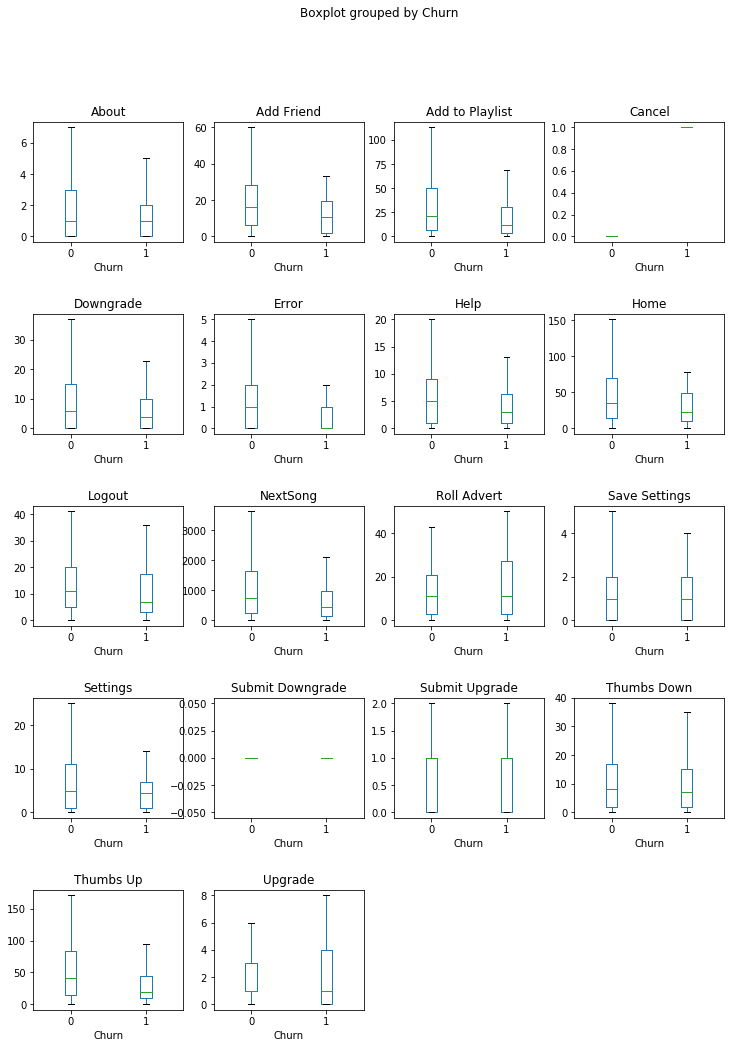

In [29]:
# Visualize the data from the table above with boxplots for both active and churn groups to see if we observe certain behaviors
pages_col = dfpd_pages.columns.drop('Churn')
fig = plt.figure(figsize=(12, 20))
fig.subplots_adjust(hspace=0.6, wspace=2.0)
for i in range(1, len(pages_col)):
    ax = fig.add_subplot(6, 4, i)
    dfpd_pages.boxplot(pages_col[i], ax = ax, grid = False, by='Churn', showfliers=False)

In [30]:
# Average number of Sessions between active and churned users
num_sessions = (df_valid.select('userId', 'Churn', 'sessionId')
                         .groupBy('userId', 'Churn')
                         .agg(countDistinct('sessionId').alias('numSessions')))

In [31]:
num_sessions.groupby(num_sessions.Churn).agg({'numSessions':'avg'}).show()

+-----+------------------+
|Churn|  avg(numSessions)|
+-----+------------------+
|    1|10.326923076923077|
|    0|15.254335260115607|
+-----+------------------+



In [32]:
# Average length of songs played by active vs churned

# first get total length of song (from NextSong page) for both groups
song_length = (df_valid.filter(df_valid.page == 'NextSong')
                       .groupby('Churn')
                       .agg(sum('length').alias('total_length')))
song_length.show()

+-----+-------------------+
|Churn|       total_length|
+-----+-------------------+
|    1|  9048741.964670053|
|    0|4.777688018193114E7|
+-----+-------------------+



In [33]:
# reuse user_count defined above to calculate average length per user (churned vs active)
avg_song_length = song_length.join(user_count, song_length.Churn == user_count.Churn).drop(user_count.Churn)
avg_song_length = avg_song_length.withColumn("avg length", avg_song_length['total_length']/avg_song_length['count(DISTINCT userId)'])
avg_song_length.show()

+-------------------+-----+----------------------+------------------+
|       total_length|Churn|count(DISTINCT userId)|        avg length|
+-------------------+-----+----------------------+------------------+
|  9048741.964670053|    1|                    52|174014.26855134717|
|4.777688018193114E7|    0|                   173|276166.93746781006|
+-------------------+-----+----------------------+------------------+



In [34]:
# User Agents

# Use StringIndexer to encode user agent
# https://spark.apache.org/docs/latest/ml-features#stringindexer
user_agents= df_valid.select(['userId', 'Churn', 'userAgent']).distinct()
indexer = StringIndexer(inputCol="userAgent", outputCol="userAgentIndex")
indexed = indexer.fit(user_agents).transform(user_agents)
indexed.show()

+------+-----+--------------------+--------------+
|userId|Churn|           userAgent|userAgentIndex|
+------+-----+--------------------+--------------+
|    36|    0|"Mozilla/5.0 (Win...|           0.0|
|    97|    0|"Mozilla/5.0 (Win...|          15.0|
|200006|    0|"Mozilla/5.0 (Mac...|          26.0|
|   146|    0|"Mozilla/5.0 (Win...|           0.0|
|    63|    0|"Mozilla/5.0 (Win...|           0.0|
|100005|    1|"Mozilla/5.0 (Mac...|           2.0|
|200011|    1|"Mozilla/5.0 (Mac...|           2.0|
|   149|    0|"Mozilla/5.0 (Mac...|           5.0|
|   133|    0|"Mozilla/5.0 (Win...|          11.0|
|    52|    0|Mozilla/5.0 (Wind...|           1.0|
|100024|    1|Mozilla/5.0 (Wind...|          22.0|
|100021|    1|"Mozilla/5.0 (Mac...|           5.0|
|200004|    0|"Mozilla/5.0 (Mac...|           5.0|
|100025|    1|"Mozilla/5.0 (Mac...|          24.0|
|   134|    0|"Mozilla/5.0 (Mac...|           4.0|
|    81|    0|"Mozilla/5.0 (Mac...|           2.0|
|    16|    0|"Mozilla/5.0 (Win

In [35]:
# number of different userAgent
indexed.select('userAgentIndex').dropDuplicates().count()

56

In [36]:
# most frequent userAgent gets index 0
indexed.select(["userAgent"]).where(indexed.userAgentIndex == "0.0").show(n=1, truncate=False)

+---------------------------------------------------------------------------------------------------------------+
|userAgent                                                                                                      |
+---------------------------------------------------------------------------------------------------------------+
|"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"|
+---------------------------------------------------------------------------------------------------------------+
only showing top 1 row



In [37]:
indexed.groupBy('Churn').agg(countDistinct('userAgentIndex').alias('numUserAgent')).show()

+-----+------------+
|Churn|numUserAgent|
+-----+------------+
|    1|          29|
|    0|          51|
+-----+------------+



In [38]:
# check activity days
# min Timestamp for each user
min_ts = df_valid.select(["userId", "Churn", "ts"]).groupby("userId", "Churn").min("ts")
# max timestamp for each user
max_ts = df_valid.select(["userId", "ts"]).groupby("userId").max("ts")
# join both on userId
activeDays = min_ts.join(max_ts, on="userId")
# calculate difference in days: ms--/1000-->s--/60-->min-->/60-->h--/24-->day
activeDays = activeDays.withColumn("days_active",(activeDays["max(ts)"]-activeDays["min(ts)"])/(1000*60*60*24))
activeDays.show()

+------+-----+-------------+-------------+-------------------+
|userId|Churn|      min(ts)|      max(ts)|        days_active|
+------+-----+-------------+-------------+-------------------+
|    19|    0|1539105419000|1539159711000| 0.6283796296296297|
|100005|    1|1538407015000|1539971825000| 18.111226851851853|
|200007|    0|1539951708000|1542585306000| 30.481458333333332|
|300007|    1|1538677496000|1538705338000| 0.3222453703703704|
|    50|    0|1538622512000|1543576568000|  57.33861111111111|
|200002|    0|1538393430000|1542324354000| 45.496805555555554|
|    30|    0|1538352117000|1543622320000|  60.99771990740741|
|     8|    0|1539186658000|1543586097000|  50.91943287037037|
|100011|    1|1538414422000|1538417085000|0.03082175925925926|
|100012|    1|1538586080000|1541100900000| 29.106712962962963|
|     4|    0|1538356650000|1543595548000|  60.63539351851852|
|    65|    0|1538416736000|1543490925000|  58.72903935185185|
|   101|    1|1538358605000|1539729037000| 15.861481481

In [39]:
activeDays.select(["userId", "Churn", "days_active"]).groupby('Churn').agg({'days_active':'mean'}).show()

+-----+-----------------+
|Churn| avg(days_active)|
+-----+-----------------+
|    1|23.51464788105413|
|    0|46.99087334082638|
+-----+-----------------+



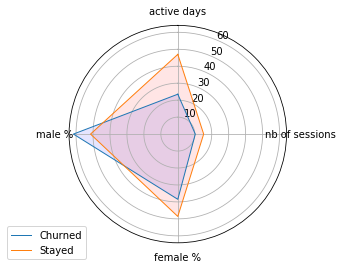

In [40]:
# Plot a spider chart showing some data points for both groups of users

# Dataframe with values calculated from above exploratory cells
df1 = pd.DataFrame({
'group': [1,0], # churn=1, stay=0
'active days': [23.51, 47],
'nb of sessions': [10.32, 15.25],
'female %': [20/52*100,84/173*100],
'male %': [32/52*100,89/173*100]
})

# number of variables
categories=list(df1)[1:]
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Churn
values=df1.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Churned")
ax.fill(angles, values, 'b', alpha=0.1)
 
# active
values=df1.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Stayed")
ax.fill(angles, values, 'r', alpha=0.1)

 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

---

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Based on the data exploration just conducted and the observed behaviors for users who stayed vs users who churned **we now need to define our features**.  
Feature engineering is the process of transforming raw data into features that better represent our underlying problem, resulting in improved model accuracy on unseen data.  
Here the features I decided to create to predict churn in our problem context:  
* user activity (pages visited - eg ThumbsUp, ThumbsDown, NextSong, etc.)
* gender
* number of sessions
* total length of played songs
* number of songs played
* Active days
* Level (latest known - paid or free)
* UserAgent

In [41]:
# lets create a features dataframe using df_valid. 
# First drop columns we do not use to speed up later operations
df_valid = df_valid.drop("artist", "auth", "firstName", "itemInSession", "lastName", "location", "method", "registration", "status")
df_valid.printSchema()

root
 |-- gender: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- page: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- Churn: integer (nullable = false)



* **Create relevant pages visited by user (user events)**  
The way users interact with the app can be a good indicator of churn

In [42]:
# similar to what we've done in data exploration, let's create a pivot on pages and count events by users
# again check https://databricks.com/blog/2016/02/09/reshaping-data-with-pivot-in-apache-spark.html for pivot reshaping
df_features = df_valid.groupby('userId').pivot('page').count().fillna(0)

# remove less significant pages from our features
# Cancel is redundant with Cancellation, login/About/Save Settings are not events I want to track as part of features
df_features = df_features.drop('About', 'Cancel', 'Login', 'Save Settings')
                                 
df_features = df_features.withColumnRenamed("Cancellation Confirmation", "Churn")
df_features.show(5)

+------+----------+---------------+-----+---------+-----+----+----+------+--------+-----------+--------+----------------+--------------+-----------+---------+-------+
|userId|Add Friend|Add to Playlist|Churn|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+----------+---------------+-----+---------+-----+----+----+------+--------+-----------+--------+----------------+--------------+-----------+---------+-------+
|200002|         4|              8|    0|        5|    0|   2|  20|     5|     387|          7|       3|               0|             1|          6|       21|      2|
|100010|         4|              7|    0|        0|    0|   2|  11|     5|     275|         52|       0|               0|             0|          5|       17|      2|
|   125|         0|              0|    1|        0|    0|   0|   0|     0|       8|          1|       0|               0|             0|          0|        0|      0

* **Gender**  
Gender could be a predictor of churn if the app has some uncovered bias toward a specific gender (UX, songs available, other social phenomenom)

In [43]:
# replace M with 0 and F with 1
df_valid = df_valid.withColumn('gender_num', when(df_valid.gender=="M", 0).otherwise(1))

gender = df_valid.select(['userId','gender_num']).distinct()
df_features = df_features.join(gender, on = 'userId', how = 'left')

* **Number of sessions**  
How often users logs and interact with the app is another important feature to consider

In [44]:
numSessions = (df_valid.select(["userId", "sessionId"])
                       .groupby("userId")
                       .agg(countDistinct('sessionId').alias('num_Sessions')))

df_features = df_features.join(numSessions, on = 'userId', how = 'left')

* **Total length of songs played**  
Playing songs is the main service from the app so how long users listen to songs and how may songs they play is key

In [45]:
total_length = (df_valid.filter(df_valid.page == 'NextSong')
                        .groupby('userId')
                        .agg(sum('length').alias('total_length')))

df_features = df_features.join(total_length, on = 'userId', how = 'left')

* **Count of songs played**

In [46]:
# count number of songs played by each user
songs_count = (df_valid.filter(df_valid.page == 'NextSong')
                       .groupBy('userId')
                       .agg(count('song').alias('count_song')))

df_features = df_features.join(songs_count, on = 'userId', how = 'left')

* **Active days**  
Number of days each user spent using the app as per log entries (latest use minus first use of the app => max timestamp - min timestamp)

In [47]:
# min_ts represents the timestamp when users start navigating the application (different from registration)
# min timestamp for each user
min_ts = df_valid.select(["userId", "ts"]).groupby("userId").min("ts")
# max timestamp for each user
max_ts = df_valid.select(["userId", "ts"]).groupby("userId").max("ts")
# join both on userId
activeDays = min_ts.join(max_ts, on="userId")
# calculate difference in days: ms--/1000-->s--/60-->min-->/60-->h--/24-->day
activeDays = activeDays.withColumn("days_active",(activeDays["max(ts)"]-activeDays["min(ts)"])/(1000*60*60*24))
# select userId and days_active to prepare for joining
activeDays = activeDays.select(["userId", "days_active"])
# join
df_features = df_features.join(activeDays, on = 'userId', how = 'left')

* **Latest known level**  
Level of users (paid or free) could be a good indicator of churn. However, as described in the problem statement and seen during exploration, users can switch between paid and free levels during their interaction with the application. It means that a same user could have different levels in the logs timeline (135 out of 225 users switch levels). I'm assigning the latest level known for the user based on timestamp.  

In [48]:
# I'm using the sort as I discovered that when sorted in descending order and applying dropDuplicates 
# it keeps the entry with the highest sorted ts so the correct latest level known for this user

# with sort
df_valid.select(['userId','level']).sort("ts", ascending=False).dropDuplicates(['userId']).show(5)

+------+-----+
|userId|level|
+------+-----+
|100010| free|
|200002| paid|
|   125| free|
|   124| paid|
|    51| paid|
+------+-----+
only showing top 5 rows



In [49]:
# without sort
df_valid.select(['userId','level']).dropDuplicates(['userId']).show(5)

+------+-----+
|userId|level|
+------+-----+
|100010| free|
|200002| free|
|   125| free|
|   124| paid|
|    51| paid|
+------+-----+
only showing top 5 rows



In [50]:
# checking on user 200002 we see this user switched from free to paid and its latest known level is paid not free
# this is confirmed with other userId in the same case whether they switch from paid to free or free to paid
df_valid.select(["userId", "ts", "page", "level"]).where(df_valid.userId == "200002").sort("ts", ascending=False).collect()

[Row(userId='200002', ts=1542324354000, page='Thumbs Up', level='paid'),
 Row(userId='200002', ts=1542324353000, page='NextSong', level='paid'),
 Row(userId='200002', ts=1542324151000, page='NextSong', level='paid'),
 Row(userId='200002', ts=1542323899000, page='NextSong', level='paid'),
 Row(userId='200002', ts=1542323729000, page='NextSong', level='paid'),
 Row(userId='200002', ts=1542323556000, page='NextSong', level='paid'),
 Row(userId='200002', ts=1542323343000, page='NextSong', level='paid'),
 Row(userId='200002', ts=1542323113000, page='NextSong', level='paid'),
 Row(userId='200002', ts=1542323001000, page='NextSong', level='paid'),
 Row(userId='200002', ts=1542322759000, page='NextSong', level='paid'),
 Row(userId='200002', ts=1542322708000, page='About', level='paid'),
 Row(userId='200002', ts=1542322606000, page='NextSong', level='paid'),
 Row(userId='200002', ts=1542322418000, page='NextSong', level='paid'),
 Row(userId='200002', ts=1542322265000, page='NextSong', level='pa

In [51]:
# free level = 0, paid =1
df_valid = df_valid.withColumn('level_num', when(df_valid.level=="free", 0).otherwise(1))
level = df_valid.select(['userId','level_num']).sort("ts", ascending=False).dropDuplicates(['userId'])
df_features = df_features.join(level, on = 'userId', how = 'left')

* **User agent**  
Maybe the technology stack (browser, OS) could explain churn or uncover issues in the application with certain platforms then churn

In [52]:
# We need to one-hot encode the user agent feature

# first we select UserAgent
user_agents= df_valid.select(['userId', 'userAgent']).distinct()

In [53]:
# check if any missing values
user_agents.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in user_agents.columns]).show()

+------+---------+
|userId|userAgent|
+------+---------+
|     0|        0|
+------+---------+



In [54]:
# we then create the indexed dataframe with StringIndexer
# https://spark.apache.org/docs/latest/ml-features#stringindexer
indexer = StringIndexer(inputCol="userAgent", outputCol="userAgentIndex")
user_agents = indexer.fit(user_agents).transform(user_agents)

In [55]:
# finally we encode with One-hot encoder
# https://spark.apache.org/docs/latest/ml-features.html#onehotencoderestimator
encoder = OneHotEncoderEstimator(inputCols=["userAgentIndex"], outputCols=["userAgentVec"])
user_agents = encoder.fit(user_agents).transform(user_agents).select(['userId', 'userAgentVec'])
user_agents.show(5)

+------+---------------+
|userId|   userAgentVec|
+------+---------------+
|200021|(55,[23],[1.0])|
|   156| (55,[6],[1.0])|
|100010| (55,[8],[1.0])|
|     7|(55,[22],[1.0])|
|   117| (55,[0],[1.0])|
+------+---------------+
only showing top 5 rows



In [56]:
# add to features dataframe
df_features = df_features.join(user_agents, on = 'userId', how = 'left')

Finalize preparation of Features for modeling

In [57]:
# Churn column is our 'label' for supervised learning
df_features = df_features.withColumnRenamed('Churn', 'label')
# userId column is not needed anymore
df_features = df_features.drop("userId")
# fill any missing values with 0 just in case
df_features = df_features.fillna(0)

In [58]:
df_features.printSchema()

root
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- label: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Logout: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Settings: long (nullable = true)
 |-- Submit Downgrade: long (nullable = true)
 |-- Submit Upgrade: long (nullable = true)
 |-- Thumbs Down: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- Upgrade: long (nullable = true)
 |-- gender_num: integer (nullable = true)
 |-- num_Sessions: long (nullable = true)
 |-- total_length: double (nullable = false)
 |-- count_song: long (nullable = true)
 |-- days_active: double (nullable = false)
 |-- level_num: integer (nullable = true)
 |-- userAgentVec: vector (nullable = true)



In [59]:
df_features.show(5)

+----------+---------------+-----+---------+-----+----+----+------+--------+-----------+--------+----------------+--------------+-----------+---------+-------+----------+------------+------------------+----------+-------------------+---------+---------------+
|Add Friend|Add to Playlist|label|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|gender_num|num_Sessions|      total_length|count_song|        days_active|level_num|   userAgentVec|
+----------+---------------+-----+---------+-----+----+----+------+--------+-----------+--------+----------------+--------------+-----------+---------+-------+----------+------------+------------------+----------+-------------------+---------+---------------+
|         4|              7|    0|        0|    0|   2|  11|     5|     275|         52|       0|               0|             0|          5|       17|      2|         1|           7| 66940.89735000003|       275|  44.21

In [60]:
df_features.count()

225

**Our features are now ready for modeling !**

---

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [61]:
# split data set into training and test
training_data, test_data = df_features.randomSplit([.8,.2])

In [62]:
# create a VectorAssembler to combine our features into a single vector column
# https://spark.apache.org/docs/latest/ml-features.html#vectorassembler
assembler = VectorAssembler(
                inputCols=df_features.drop("label").columns,
                outputCol="features")

In [63]:
# scale the data to a [0,1] range using a MinMaxScaler
# https://spark.apache.org/docs/latest/ml-features.html#minmaxscaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

In [64]:
# create 3 classifiers to test out
# https://spark.apache.org/docs/latest/ml-classification-regression.html
lr = LogisticRegression(labelCol="label", featuresCol="scaledFeatures")
linsvc = LinearSVC(labelCol="label", featuresCol="scaledFeatures")
rf = RandomForestClassifier(labelCol="label", featuresCol="scaledFeatures")

In [65]:
# construct our pipelines that we want to tune
lr_pipeline = Pipeline(stages=[assembler, scaler, lr])
linsvc_pipeline = Pipeline(stages=[assembler, scaler, linsvc])
rf_pipeline = Pipeline(stages=[assembler, scaler, rf])

In [66]:
# use ParamGridBuilder to construct a grid of parameters for our classifiers to search over. 
lr_paramGrid = (ParamGridBuilder().addGrid(lr.maxIter, [10, 20])
                                  .addGrid(lr.regParam, [0.1, 0.01])
                                  .build())
linsvc_paramGrid = (ParamGridBuilder().addGrid(linsvc.maxIter, [10, 20])
                                      .addGrid(linsvc.regParam,[0.01, 0.1, 0.2])
                                      .build())
rf_paramGrid = (ParamGridBuilder().addGrid(rf.numTrees, [20, 50])
                                  .addGrid(rf.maxDepth, [10, 20])
                                  #.addGrid(rf.impurity, ['gini','entropy'])
                                  .build())

In [67]:
def evaluateModel(pipeline, paramGrid, metric, train, test):
    '''
    Create and Evaluate model
    Input:
        pipeline - pipeline object
        paramGrid - associated ParamGridBuilder to construct a grid of parameters to search over
        metric - metric name to use in evaluation
        train - training data
        test - test data
    Returns:
        score - metric score
        bestModel - best model found with cross validation
    
    '''
    # set evaluation metric for best model selection
    evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName=metric)
   
    # set up 3-fold cross validation
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=3)

    # run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)
    
    # generate predictions
    prediction = cvModel.transform(test)
    
    # evaluate model on metric
    score =  evaluator.evaluate(prediction)
    
    # best model
    bestModel = cvModel.bestModel
    
    # return score and bestModel
    return [score, bestModel]

In [68]:
f1_lr, lr_model = evaluateModel(lr_pipeline, lr_paramGrid, 'f1', training_data, test_data)

In [69]:
f1_linsvc, linsvc_model = evaluateModel(linsvc_pipeline, linsvc_paramGrid, 'f1', training_data, test_data)

In [70]:
f1_rf, rf_model = evaluateModel(rf_pipeline, rf_paramGrid, 'f1', training_data, test_data)

In [71]:
print ('F1 score of Logistic Regression is:', f1_lr)
print ('F1 score of LinearSVC is:', f1_linsvc)
print ('F1 score of Random Forest is:', f1_rf)

F1 score of Logistic Regression is: 0.6666666666666667
F1 score of LinearSVC is: 0.6475376475376474
F1 score of Random Forest is: 0.815827986040752


Best performing model on F1 score is the Random Forest model. let's use it to look at feature importances.

In [72]:
# extract the feature names from the VectorAssembler object
feature_names = np.array(rf_model.stages[0].getInputCols())
# extract the feature importances from classifier
feature_imp = np.array(rf_model.stages[-1].featureImportances)

In [73]:
# as we have one-hot encoded userAgent feature we need to adjust here by summing values for each:
len(feature_imp)

76

In [74]:
len(feature_names)

22

In [75]:
# sum the feature importances of all encoded user agents and assign to userAgentVec feature
userAgentVec = np.sum(feature_imp[len(feature_names):])
# add this sum to the last feature
feature_imp = feature_imp[:len(feature_names)] + userAgentVec

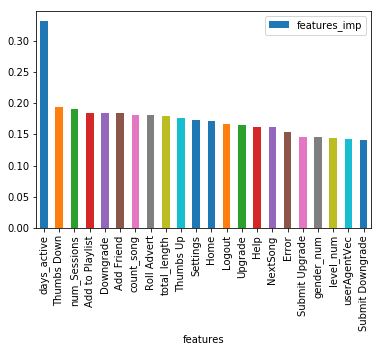

In [76]:
# Use Pandas to represent how much each feature contributes to a prediction
features_imp_df = pd.DataFrame(feature_imp, columns=["features_imp"])
features_imp_df["features"] = feature_names
ax = features_imp_df.sort_values(by=['features_imp'], ascending=False).plot.bar(x='features', y='features_imp')

According to our Random Forest model which performed best in this example, the number of days a user is using the application is the feature which contributes the most to churn prediction.   
The level (paid or free) and the action to switch from one to the other has not much contribution to churn. 

We could continue to improve our predictions by tuning our random forest model using other hyperparameters and adding values to existing ones. We could also remove some features from the model or creates new ones. Basically, continuing to iterate until we have better results on our predictions and better understing on features that contribute to our predictions. Finally, using the larger data set should increase the F1 score.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.